# Doom Deadly Corridor with Advantage Actor Critic
The purpose of this scenario is to teach the agent to navigate towards his fundamental goal (the vest) and make sure he survives at the same time.

### Enviroment
Map is a corridor with shooting monsters on both sides (6 monsters in total). A green vest is placed at the oposite end of the corridor.Reward is proportional (negative or positive) to change of the distance between the player and the vest. If player ignores monsters on the sides and runs straight for the vest he will be killed somewhere along the way.

### Action
 - MOVE_LEFT
 - MOVE_RIGHT
 - ATTACK
 - MOVE_FORWARD
 - MOVE_BACKWARD
 - TURN_LEFT
 - TURN_RIGHT

### Rewards
 - +dX for getting closer to the vest.
 - -dX for getting further from the vest.
 - -100 death penalty


## Step 1: Import the libraries

In [1]:
import numpy as np
import wandb                # For tracking and visualizing our experiments
import random
import time
import cv2
import os
import torch
from vizdoom import *        # Doom Environment
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import namedtuple, deque
import math

%matplotlib inline
os.environ["WANDB_NOTEBOOK_NAME"] = "corridor.ipynb"

In [2]:
import sys
from a2c_agent import A2CAgent
from models import ActorCnn, CriticCnn
from stack_frame import preprocess_frame, stack_frame

## Step 2: Create our environment

Initialize the environment in the code cell below.


In [3]:
def create_environment():
    game = DoomGame()
    
    # Load the correct configuration
    game.load_config("../doom files/deadly_corridor.cfg")
    
    # Load the correct scenario (in our case defend_the_center scenario)
    game.set_doom_scenario_path("../doom files/deadly_corridor.wad")
    
    # Here our possible actions
    possible_actions  = np.identity(7, dtype=int).tolist()
    
    return game, possible_actions
game, possible_actions = create_environment()

In [4]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


## Step 3: Viewing our Enviroment

The size of frame is: ( 240 ,  320 )
No. of Actions:  [[1, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 1]]


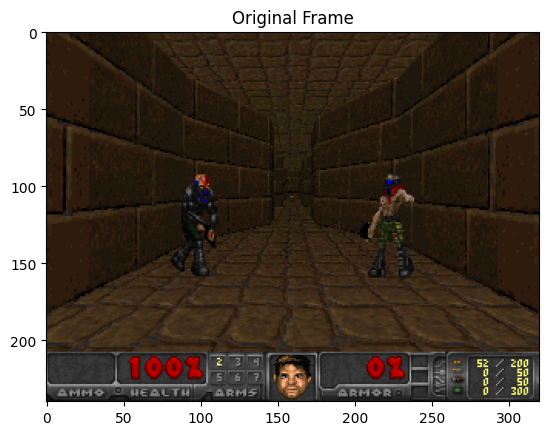

In [5]:
print("The size of frame is: (", game.get_screen_height(), ", ", game.get_screen_width(), ")")
print("No. of Actions: ", possible_actions)
game.init()
plt.figure()
plt.imshow(game.get_state().screen_buffer.transpose(1, 2, 0))
plt.title('Original Frame')
plt.show()
game.close()

### Execute the code cell below to play with a random policy.

In [6]:
def random_play():
    game.init()
    game.new_episode()
    score = 0
    while True:
        reward = game.make_action(possible_actions[np.random.randint(7)])
        done = game.is_episode_finished()
        score += reward
        time.sleep(0.01)
        if done:
            print("Your total score is: ", score)
            game.close()
            break
random_play()

Your total score is:  -208.72885131835938


## Step 4: Preprocessing Frame

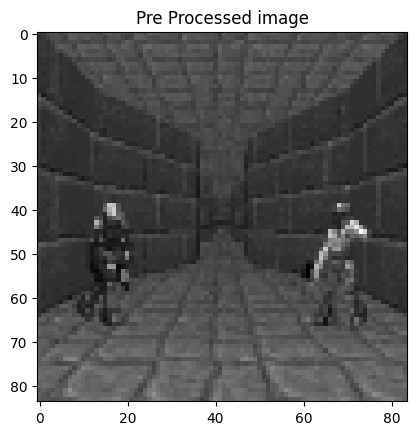

In [7]:
game.init()
plt.figure()
plt.imshow(preprocess_frame(game.get_state().screen_buffer.transpose(1, 2, 0),(0, -60, -40, 60), 84), cmap="gray")
game.close()
plt.title('Pre Processed image')
plt.show()

## Step 5: Stacking Frame

In [8]:
def stack_frames(frames, state, is_new=False):
    frame = preprocess_frame(state, (0, -60, -40, 60), 84)
    frames = stack_frame(frames, frame, is_new)

    return frames
    

## Step 6: Creating our Agent

In [9]:
INPUT_SHAPE = (4, 84, 84)
ACTION_SIZE = len(possible_actions)
EPISODES = 10_000
skiprate = 4           # how many frames to skip
SEED = 0
ALPHA= 0.001          # Actor learning rate
BETA = 0.005          # Critic learning rate
GAMMA = 0.99           # discount factor
EPSILON = 1.0          # for epsilon-greedy action selection
EPSILON_DECAY = 0.9995 # decay rate for epsilon
EPSILON_MIN = 0.05     # minimum value of epsilon
UPDATE_EVERY = 250     # how often to update the network 
actor_savefile = "models/corridor/actor.pth"
critic_savefile = "models/corridor/critic.pth"
train_model = True
save_model = True
load_model = False

agent = A2CAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, GAMMA, ALPHA, BETA, UPDATE_EVERY)

## Step 7: Watching untrained agent play

In [10]:
# watch an untrained agent
game.init()
score = 0
state = stack_frames(None, game.get_state().screen_buffer.transpose(1, 2, 0), True) 
while True:
    action, _, _= agent.act(state)
    score += game.make_action(possible_actions[action])
    done = game.is_episode_finished()
    if done:
        print("Your total score is: ", score)
        break
    else:
        state = stack_frames(state, game.get_state().screen_buffer.transpose(1, 2, 0), False)
        
game.close()

Your total score is:  -206.9558563232422


## Step 8: Loading Agent

In [11]:
agent = A2CAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, GAMMA, ALPHA, BETA, UPDATE_EVERY,
                 epsilon=EPSILON, epsilon_decay=EPSILON_DECAY, epsilon_min=EPSILON_MIN,
                 load_model=load_model, actor_model=actor_savefile, critic_model=critic_savefile)

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="vizdoom-a2c-corridor",
    
    # track hyperparameters and run metadata
    config={
    "architecture": "Advantage Actor Critic",
    "scenario": "deadly_corridor",
    "actions": possible_actions,
    "episodes": EPISODES,
    "skiprate": skiprate,
    "update_every": UPDATE_EVERY,
    "actor_learning_rate": ALPHA,
    "critic_learning_rate": BETA,
    "discount_factor": GAMMA,
    "epsilon": EPSILON,
    "epsilon_decay": EPSILON_DECAY,
    "epsilon_min": EPSILON_MIN,
    }
)

wandb.watch(agent.actor_net, log_freq=100)
wandb.watch(agent.critic_net, log_freq=100)

start_episode = 0 
scores = []

wandb: Currently logged in as: marini97. Use `wandb login --relogin` to force relogin


## Step 9: Train the Agent with Actor Critic

In [12]:
def train(n_episodes=1000):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    game.set_window_visible(False)
    game.init()
    for i_episode in range(start_episode + 1, n_episodes+1):
        game.new_episode()
        state = stack_frames(None, game.get_state().screen_buffer.transpose(1, 2, 0), True) 
        score = 0
        while True:
            action, log_prob, entropy = agent.act(state)
            reward = game.make_action(possible_actions[action], skiprate)
            done = game.is_episode_finished()
            score += reward
            if done:
                break
            else:
                next_state = stack_frames(state, game.get_state().screen_buffer.transpose(1, 2, 0), False)
                agent.step(state, log_prob, entropy, reward, done, next_state)
                state = next_state
        scores.append(score)              # save most recent score
        
        # save the model weights
        wandb.log({"epsilon": agent.epsilon, "loss": agent.loss, "score": score})
        
        print('\rEpisode {}\tAverage Score: {:.2f},\tEpsilon: {:.4f},\tLoss: {:.4f}'.format(i_episode, np.mean(scores), agent.epsilon, agent.loss), end="")

        # save the networks        
        if save_model and i_episode % 1000 == 0:
            actor_savefile = "models/corridor/actor_{}.pth".format(i_episode)
            critic_savefile = "models/corridor/critic_{}.pth".format(i_episode)
            print("\nSaving the networks to file: ", actor_savefile, critic_savefile)
            torch.save(agent.actor_net, actor_savefile)
            torch.save(agent.critic_net, critic_savefile)
            
    game.close()
    
    if save_model:
        torch.save(agent.actor_net, "models/corridor/actor.pth")
        torch.save(agent.critic_net, "models/corridor/critic.pth")
    
    return scores

In [13]:
%%wandb

if train_model:    
    scores = train(EPISODES)

Episode 1000	Average Score: -28.02,	Epsilon: 0.0500,	Loss: 6752.250758
Saving the networks to file:  models/corridor/actor_1000.pth models/corridor/critic_1000.pth
Episode 2000	Average Score: 26.69,	Epsilon: 0.0500,	Loss: 5809.253378
Saving the networks to file:  models/corridor/actor_2000.pth models/corridor/critic_2000.pth
Episode 3000	Average Score: 46.81,	Epsilon: 0.0500,	Loss: 4473.00285
Saving the networks to file:  models/corridor/actor_3000.pth models/corridor/critic_3000.pth
Episode 3302	Average Score: 50.03,	Epsilon: 0.0500,	Loss: 37433.9265

## Step 10: Watch a Smart Agent!

In [ ]:
# watch an trained agent
for i in range(10):
    game.init()
    score = 0
    state = stack_frames(None, game.get_state().screen_buffer.transpose(1, 2, 0), True) 
    while True:
        action, _, _= agent.act(state)
        score += game.make_action(possible_actions[action])
        done = game.is_episode_finished()
        if done:
            print("Your total score is: ", score)
            break
        else:
            state = stack_frames(state, game.get_state().screen_buffer.transpose(1, 2, 0), False)
            
    game.close()